Total epochs logged: 1142
Displaying from epoch 0: 1142 epochs
NaN epochs: train=20, val=16
Outliers filtered (>1000x median): train=20, val=16


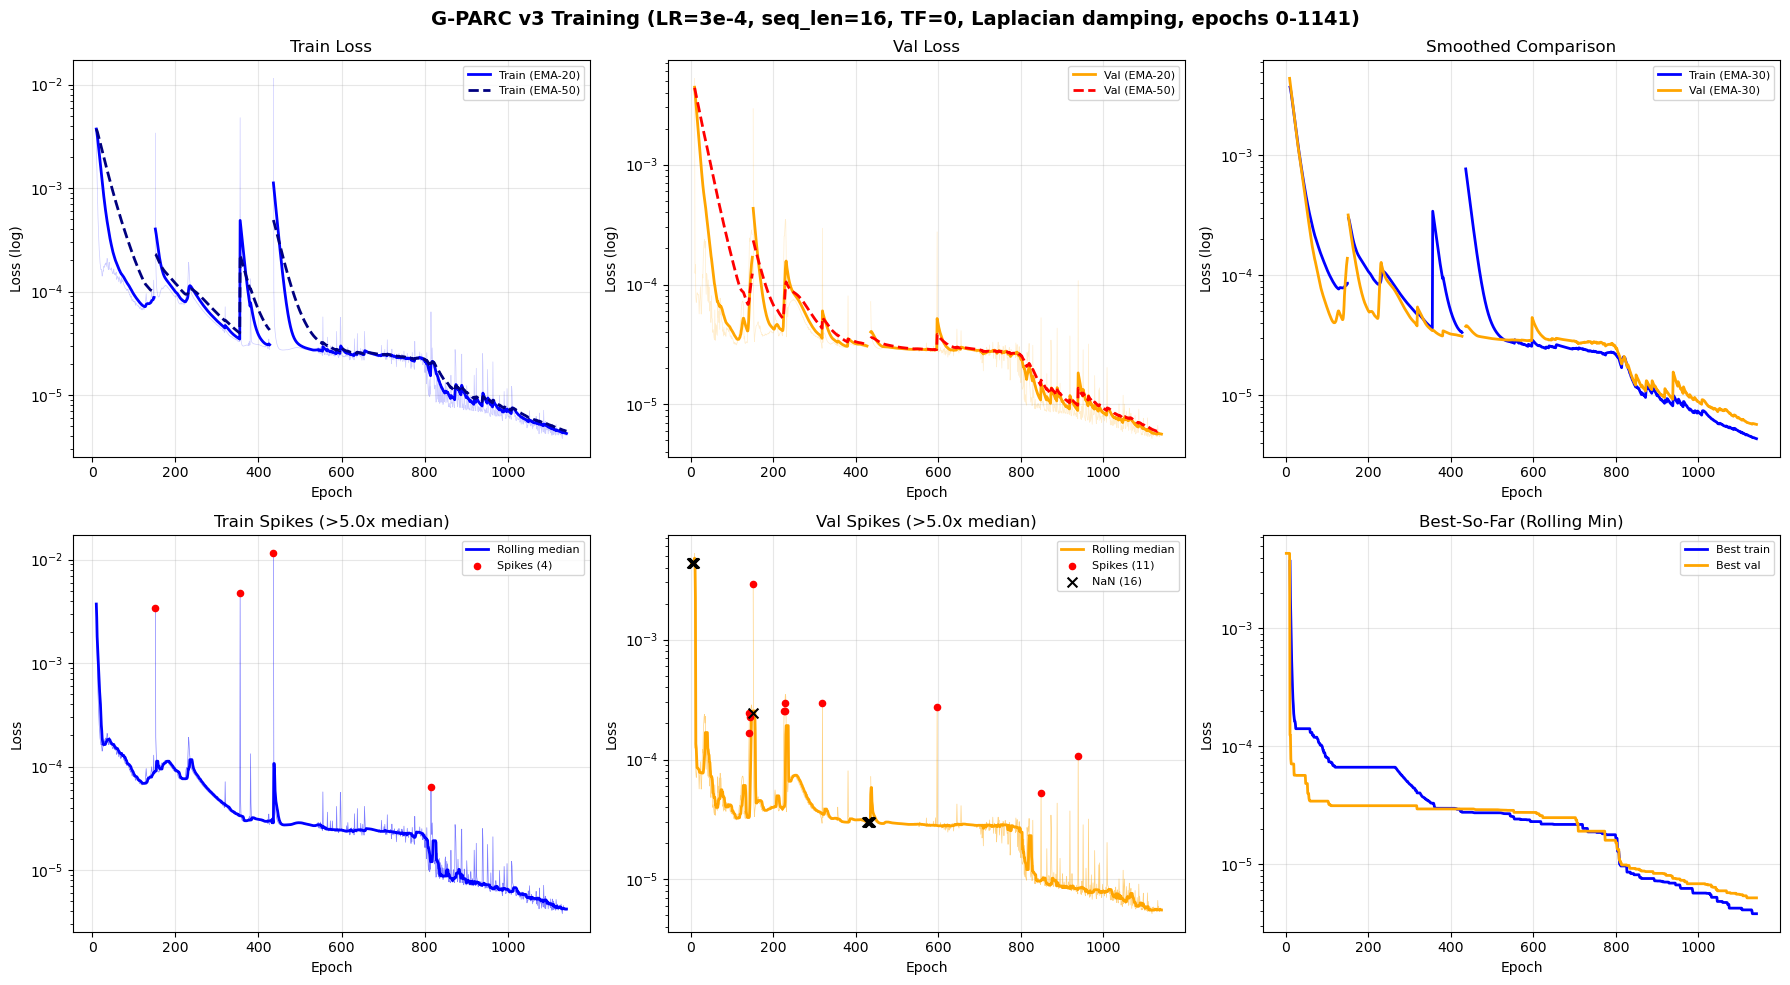

✅ Saved: v3_loss_analysis.png

G-PARC v3 TRAINING STATUS
  Current epoch: 1141
  Train loss:    4.10e-06
  Val loss:      5.55e-06
  Best val:      5.17e-06 (epoch 1118)
  Train spikes:  4/1142 epochs
  Val spikes:    11/1142 epochs
  NaN epochs:    train=20, val=16

  Val loss improving? YES (EMA-50 dropped 15.0% over last 50 valid epochs)


In [1]:
#!/usr/bin/env python3
"""
Training Diagnostics for G-PARC v3 (Laplacian Damping)
- Smoothed loss curves to see trends through noise
- Spike detection and analysis
- Rolling statistics
- NaN-safe throughout
"""
import matplotlib.pyplot as plt
import json
import numpy as np
from pathlib import Path

# ============================================================
# LOAD DATA
# ============================================================
history_path = '/scratch/jtb3sud/elasto_graphconv_V2/gparcv1/training_history.json'
#history_path = '/scratch/jtb3sud/elasto_graphconv_V2/global_max_v3_seq34full/training_history.json'
with open(history_path) as f:
    hist = json.load(f)

train_loss_raw = np.array([x if x is not None else np.nan for x in hist['train_loss']], dtype=np.float64)
val_loss_raw = np.array([x if x is not None else np.nan for x in hist['val_loss']], dtype=np.float64)

# Mark inf as NaN too
train_loss_raw[~np.isfinite(train_loss_raw)] = np.nan
val_loss_raw[~np.isfinite(val_loss_raw)] = np.nan

# Filter extreme outliers (>1000x median) — these corrupt EMA
train_med = np.nanmedian(train_loss_raw)
val_med = np.nanmedian(val_loss_raw)
OUTLIER_FACTOR = 1000
train_outliers = train_loss_raw > train_med * OUTLIER_FACTOR
val_outliers = val_loss_raw > val_med * OUTLIER_FACTOR
train_loss_raw[train_outliers] = np.nan
val_loss_raw[val_outliers] = np.nan

# Trim early epochs if desired
SKIP = 0
train_loss = train_loss_raw[SKIP:]
val_loss = val_loss_raw[SKIP:]
epochs = np.arange(SKIP, SKIP + len(train_loss))

n_nan_train = np.sum(np.isnan(train_loss))
n_nan_val = np.sum(np.isnan(val_loss))
n_outlier_train = train_outliers[SKIP:].sum()
n_outlier_val = val_outliers[SKIP:].sum()
print(f"Total epochs logged: {len(train_loss_raw)}")
print(f"Displaying from epoch {SKIP}: {len(train_loss)} epochs")
print(f"NaN epochs: train={n_nan_train}, val={n_nan_val}")
print(f"Outliers filtered (>{OUTLIER_FACTOR}x median): train={n_outlier_train}, val={n_outlier_val}")

# ============================================================
# NaN-SAFE HELPERS
# ============================================================
def smooth(y, window=20):
    """EMA that skips NaN values."""
    alpha = 2 / (window + 1)
    result = np.full_like(y, np.nan)
    last_valid = np.nan
    for i in range(len(y)):
        if np.isfinite(y[i]):
            if np.isnan(last_valid):
                last_valid = y[i]
            else:
                last_valid = alpha * y[i] + (1 - alpha) * last_valid
            result[i] = last_valid
    return result

def nan_rolling_median(y, window=10):
    """Rolling median that ignores NaN."""
    result = np.full_like(y, np.nan)
    for i in range(len(y)):
        chunk = y[max(0, i - window):i + 1]
        valid = chunk[np.isfinite(chunk)]
        if len(valid) > 0:
            result[i] = np.median(valid)
    return result

def nan_rolling_min(y):
    """Cumulative min that skips NaN."""
    result = np.full_like(y, np.nan)
    best = np.inf
    for i in range(len(y)):
        if np.isfinite(y[i]):
            best = min(best, y[i])
            result[i] = best
        elif np.isfinite(best):
            result[i] = best
    return result

# ============================================================
# FIGURE: LOSS CURVES
# ============================================================
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1a. Raw + smoothed train loss
ax = axes[0, 0]
ax.plot(epochs, train_loss, alpha=0.2, color='blue', linewidth=0.5)
ax.plot(epochs, smooth(train_loss, 20), color='blue', linewidth=2, label='Train (EMA-20)')
ax.plot(epochs, smooth(train_loss, 50), color='navy', linewidth=2, linestyle='--', label='Train (EMA-50)')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log)')
ax.set_title('Train Loss')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 1b. Raw + smoothed val loss
ax = axes[0, 1]
ax.plot(epochs, val_loss, alpha=0.2, color='orange', linewidth=0.5)
ax.plot(epochs, smooth(val_loss, 20), color='orange', linewidth=2, label='Val (EMA-20)')
ax.plot(epochs, smooth(val_loss, 50), color='red', linewidth=2, linestyle='--', label='Val (EMA-50)')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log)')
ax.set_title('Val Loss')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 1c. Both smoothed on same axes
ax = axes[0, 2]
ax.plot(epochs, smooth(train_loss, 30), color='blue', linewidth=2, label='Train (EMA-30)')
ax.plot(epochs, smooth(val_loss, 30), color='orange', linewidth=2, label='Val (EMA-30)')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss (log)')
ax.set_title('Smoothed Comparison')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 2a. Spike analysis - train
ax = axes[1, 0]
rolling_median_train = nan_rolling_median(train_loss, window=10)
spike_threshold = 5.0
train_spikes = train_loss > (rolling_median_train * spike_threshold)
train_spikes[np.isnan(train_loss)] = False
ax.plot(epochs, train_loss, alpha=0.5, color='blue', linewidth=0.5)
ax.plot(epochs, rolling_median_train, color='blue', linewidth=2, label='Rolling median')
ax.scatter(epochs[train_spikes], train_loss[train_spikes], color='red', s=20, zorder=5, label=f'Spikes ({train_spikes.sum()})')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Train Spikes (>{spike_threshold}x median)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 2b. Spike analysis - val
ax = axes[1, 1]
rolling_median_val = nan_rolling_median(val_loss, window=10)
val_spikes = val_loss > (rolling_median_val * spike_threshold)
val_spikes[np.isnan(val_loss)] = False
# Mark NaN epochs with a different marker
nan_mask = np.isnan(val_loss)
ax.plot(epochs, val_loss, alpha=0.5, color='orange', linewidth=0.5)
ax.plot(epochs, rolling_median_val, color='orange', linewidth=2, label='Rolling median')
ax.scatter(epochs[val_spikes], val_loss[val_spikes], color='red', s=20, zorder=5, label=f'Spikes ({val_spikes.sum()})')
if nan_mask.any():
    # Plot NaN epochs as X markers at the rolling median level
    ax.scatter(epochs[nan_mask], rolling_median_val[nan_mask], color='black', s=50, marker='x',
               zorder=6, label=f'NaN ({nan_mask.sum()})')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title(f'Val Spikes (>{spike_threshold}x median)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

# 2c. Rolling min (best-so-far trajectory)
ax = axes[1, 2]
rolling_min_train = nan_rolling_min(train_loss)
rolling_min_val = nan_rolling_min(val_loss)
ax.plot(epochs, rolling_min_train, color='blue', linewidth=2, label='Best train')
ax.plot(epochs, rolling_min_val, color='orange', linewidth=2, label='Best val')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Best-So-Far (Rolling Min)')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.suptitle(f'G-PARC v3 Training (LR=3e-4, seq_len=16, TF=0, Laplacian damping, epochs {epochs[0]}-{epochs[-1]})',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('v3_loss_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
plt.close()
print("✅ Saved: v3_loss_analysis.png")

# ============================================================
# CONSOLE SUMMARY
# ============================================================
valid_train = train_loss[np.isfinite(train_loss)]
valid_val = val_loss[np.isfinite(val_loss)]

final_train = valid_train[-1]
final_val = valid_val[-1]
best_val = np.nanmin(val_loss)
best_val_epoch = epochs[np.nanargmin(val_loss)]

print(f"\n{'='*60}")
print("G-PARC v3 TRAINING STATUS")
print(f"{'='*60}")
print(f"  Current epoch: {epochs[-1]}")
print(f"  Train loss:    {final_train:.2e}")
print(f"  Val loss:      {final_val:.2e}")
print(f"  Best val:      {best_val:.2e} (epoch {best_val_epoch})")
print(f"  Train spikes:  {train_spikes.sum()}/{len(train_loss)} epochs")
print(f"  Val spikes:    {val_spikes.sum()}/{len(val_loss)} epochs")
print(f"  NaN epochs:    train={n_nan_train}, val={n_nan_val}")
print(f"\n  Val loss improving? ", end="")
ema50 = smooth(val_loss, 50)
# Get indices where EMA is valid
finite_mask = np.isfinite(ema50)
finite_indices = np.where(finite_mask)[0]
if len(finite_indices) > 50:
    recent_trend = ema50[finite_indices[-1]] / ema50[finite_indices[-50]]
    if recent_trend < 0.9:
        print(f"YES (EMA-50 dropped {(1-recent_trend)*100:.1f}% over last 50 valid epochs)")
    elif recent_trend < 1.0:
        print(f"SLOWLY ({(1-recent_trend)*100:.1f}% over last 50 valid epochs)")
    else:
        print(f"PLATEAU/RISING ({(recent_trend-1)*100:.1f}% increase over last 50 valid epochs)")
else:
    print("Not enough data yet")
print(f"{'='*60}")